## 1 PyTorch Serve

## Instructions

```
                                         1.2 Create an archive

                                       ┌──────────────────────┐
                                       │                      │
                                       │   Torchserve Model   │
                                       │       Archive        │
                                       │                      │
                                       │   ┌──────────────┐   │   ┌──────────────┐
                                       │   │              │   │   │              │              1.3
 1.1.1 custom model checkpoint ────────┼─► ├torchscript.pt┤   │   │  Torchserve  │              # workers
                                       │   │              │   │   │              │ ◄──────────  # batchsize
                                       │   └──────────────┘   │   │    config    │              max batch delay
                                       │                      │   │              │              etc.
        preprocess  code               │   ┌──────────────┐   │   └──────┬───────┘
1.1.2      call model     ─────────────┼─► │  handler.py  │   │          │
        postprocess code               │   └──────────────┘   │          │
                                       │                      │          │
                                       └──────────┬───────────┘          │
                                                  │                      │
                                                  │                      │
                                                  │                      │
                                       ┌──────────▼──────────────────────▼───────┐
                                       │                                         │    1.4 Upload to storage
                                       │   Storage   ( MinIO / S3 / Url / PVC )  │
                                       │                                         │
                                       └────────────────────┬────────────────────┘
                                                            │
                                       ┌────────────────────▼────────────────────┐
                                       │                                         │    2 Define KServe Yaml
                                       │             KServe Predictor            │
                                       │                                         │    3 Do some basic testing
                                       │             ( scaling pods )            │
                                       │                                         │    4 Autoscaling
                                       └─────────────────────────────────────────┘
                                                                                      5 Canary Rollout
     
 ```
 
The lab mainly covers:
- PyTorch Serve: package PyTorch model with custom preprocess/postprocess functions
- MinIO storage usage
- KServe: basic, autoscaling, canary rollout

#### 1.1 Prepartion for Model Archiver

Prepare 3 files:
- helmet.pt: fine-tuning the model with your own data and save the parameters
- helmet.torchscript.pt: a serialized file (.pt or .pth) should be a checkpoint in case of torchscript and state_dict in case of eager mode.
- handler.py: codes for model initialization, pre-processing, post-processing, etc.


##### 1.1.1 helmet.pt

All files in worker@10.186.48.212:/home/worker/helmet/yolov5_torchserve 

- Label, Process, Split your custom data

`python prepare.py`

- To fine-tune the model and save the checkpoint

`python train`

- Detect and Test

`python detect.py --source 2.jpg --weights helmet.pt`

##### 1.1.2 helmet.torchscript.pt

The helmet.torchscript.pt provide model architecture definition and checkpoints with torchserve.

Export helmet.torchscript.pt

`python export.py --weights helmet.pt --include torchscript`

Learn more about eager-mode vs torchscript here:
https://pytorch.org/tutorials/beginner/deploy_seq2seq_hybrid_frontend_tutorial.html

In [1]:
!mkdir -p torchserve

##### 1.1.3 Handler.py

What can handler.py do? (https://pytorch.org/serve/custom_service.html)

- Initialize the model instance
- Pre-process input data before it is sent to the model for inference or Captum explanations
- Customize how the model is invoked for inference or explanations
- Post-process output from the model before sending back a response

In [2]:
%%writefile torchserve/torchserve_handler.py
# custom handler file

"""Custom TorchServe model handler for YOLOv5 models.
"""

from ts.torch_handler.base_handler import BaseHandler
import numpy as np
import base64
import torch
import torchvision.transforms as tf
import torchvision
import io
from PIL import Image
import warnings

# model_handler.py

# BaseHandler:
# https://github.com/pytorch/serve/blob/master/ts/torch_handler/base_handler.py


class ModelHandler(BaseHandler):
    """
    A custom model handler implementation.
    """

    img_size = 640
    """Image size (px). Images will be resized to this resolution before inference.
    """

    def __init__(self):
        # call superclass initializer
        super().__init__()
        self._context = None
        self.initialized = False
        self.batch_size = 1
        self.img_size = 640

    def preprocess(self, data):
        """Converts input images to float tensors.
        Args:
            data (List): Input data from the request in the form of a list of image tensors.
        Returns:
            Tensor: single Tensor of shape [BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE]
        """
        images = []

        transform = tf.Compose([
            tf.ToTensor(),
            tf.Resize((self.img_size, self.img_size))
        ])

        # Method 1
        # image = data[0].get("data") or data[0].get("body")
        image = data[0]

        if image is None:
            warnings.warn("data params is none")
            raise Exception("no data")
        else:
            if isinstance(image, str):
                # if the image is a string of bytesarray.
                image = base64.b64decode(image)

            # If the image is sent as bytesarray
            if isinstance(image, (bytearray, bytes)):
                image = Image.open(io.BytesIO(image))
            else:
                # if the image is a list
                image = torch.FloatTensor(image)

            # force convert to tensor
            # and resize to [img_size, img_size]
            image = transform(image)

            images.append(image)

        # convert list of equal-size tensors to single stacked tensor
        # has shape BATCH_SIZE x 3 x IMG_SIZE x IMG_SIZE
        images_tensor = torch.stack(images).to(self.device)

        return images_tensor

    def postprocess(self, inference_output):
        # perform NMS (nonmax suppression) on model outputs
        pred = non_max_suppression(inference_output[0])

        # initialize empty list of detections for each image
        detections = [[] for _ in range(len(pred))]

        for i, image_detections in enumerate(pred):  # axis 0: for each image
            for det in image_detections:  # axis 1: for each detection
                # x1,y1,x2,y2 in normalized image coordinates (i.e. 0.0-1.0)
                xyxy = det[:4] / self.img_size
                # confidence value
                conf = det[4].item()
                # index of predicted class
                class_idx = int(det[5].item())
                # get label of predicted class
                # if missing, then just return class idx
                label = self.mapping.get(str(class_idx), class_idx)

                detections[i].append({
                    "x1": xyxy[0].item(),
                    "y1": xyxy[1].item(),
                    "x2": xyxy[2].item(),
                    "y2": xyxy[3].item(),
                    "confidence": conf,
                    "class": label
                })

        # format each detection
        return detections


def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False,
                        labels=(), max_det=300):
    """Runs Non-Maximum Suppression (NMS) on inference results
    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    nc = prediction.shape[2] - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

    # Settings
    # (pixels) minimum and maximum box width and height
    min_wh, max_wh = 2, 4096
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 10.0  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    output = [torch.zeros((0, 6), device=prediction.device)
              ] * prediction.shape[0]
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            l = labels[xi]
            v = torch.zeros((len(l), nc + 5), device=x.device)
            v[:, :4] = l[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[
                conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            # sort by confidence
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        # boxes (offset by class), scores
        boxes, scores = x[:, :4] + c, x[:, 4]
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = torchvision.box_iou(
                boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float(
            ) / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]

    return output


def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

Writing torchserve/torchserve_handler.py


#### 1.2 Torchserve Model Archiver

It basically create a tar called `{model-name}.mar` from `model-file`, `serialized-file (*.pt)`, `handler`

In [7]:
%%bash
cd $(dirname $0)/torchserve
base_path=$(pwd)

mkdir -p $base_path/model-store && cd $base_path/model-store &&
if [ -f $base_path/model-store/helmet_detection.mar ]; then
    rm $base_path/model-store/helmet_detection.mar
fi

pip install torch-model-archiver -i https://pypi.tuna.tsinghua.edu.cn/simple


torch-model-archiver --model-name helmet_detection \
--version 0.1 --serialized-file $base_path/helmet.torchscript.pt \
--handler $base_path/torchserve_handler.py \
--extra-files $base_path/index_to_name.json,$base_path/torchserve_handler.py


echo "create successfully"

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
create successfully


#### 1.3 create torchserve config

Feel free to change the parameters:

- minWorkers: the minimum number of workers of a model
- maxWorkers: the maximum number of workers of a model
- batchSize: the batch size of a model
- maxBatchDelay: the maximum dalay in msec of a batch of a model
- responseTimeout: the timeout in msec of a model's response
- defaultVersion: the default version of a model
- marName: the mar file name of a model


In [8]:
!mkdir -p torchserve/config

In [9]:
%%writefile torchserve/config/config.properties

inference_address=http://0.0.0.0:8085
management_address=http://0.0.0.0:8081
metrics_address=http://0.0.0.0:8082
grpc_inference_port=7070
grpc_management_port=7071
enable_metrics_api=true
metrics_format=prometheus
number_of_netty_threads=4
job_queue_size=10
enable_envvars_config=true
install_py_dep_per_model=true
model_store=/home/model-server/torchserve_mar/helmet_detection/model-store
model_snapshot={"name":"startup.cfg","modelCount":1,"models":{"helmet_detection":{"1.0":{"defaultVersion":true,"marName":"helmet_detection.mar","minWorkers":1,"maxWorkers":5,"batchSize":4,"maxBatchDelay":100,"responseTimeout":120}}}}

Writing torchserve/config/config.properties


#### 1.4 Upload to MinIO

If you already have the minio storage, you can directly follow the next steps. If not, we also provide a standalone minio deployment guide on the kubernetes clusters.

You can use the files from here [https://github.com/xujinheng/kubeflow-manifests/tree/main/website/content/en/docs/kubeflow-tutorial/lab4_minio_deploy], and apply in your clusters.

`kubectl apply -f minio-standalone-pvc.yml` 

`kubectl apply -f minio-standalone-service.yml`

`kubectl apply -f minio-standalone-deployment.yml`

This step uploads `torchserve/model-store`, `torchserve/config` to MinIO buckets

You need to find the MINIO
- `endpoint_url`
- `key_id`
- `access_key`

In [10]:
!pip install boto3 -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 21.1 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 11.1 MB/s eta 0:00:00


In [11]:
import os
from urllib.parse import urlparse
import boto3

os.environ["AWS_ENDPOINT_URL"] = "http://10.105.150.55:9000"
os.environ["AWS_REGION"] = "us-east-1"
os.environ["AWS_ACCESS_KEY_ID"] = "minioadmin"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minioadmin"

s3 = boto3.resource('s3',
                    endpoint_url=os.getenv("AWS_ENDPOINT_URL"),
                    verify=True)

In [12]:
print("current buckets in s3:")
print(list(s3.buckets.all()))

current buckets in s3:
[]


In [13]:
bucket_name='helmet-bucket'
s3.create_bucket(Bucket=bucket_name)

s3.Bucket(name='helmet-bucket')

Upload files to your bucket_name, and you can also specify `bucket_path`

In [14]:
curr_path = os.getcwd()
base_path = os.path.join(curr_path, "torchserve")


bucket_path = "helmet_detection"

bucket = s3.Bucket(bucket_name)

# upload
bucket.upload_file(os.path.join(base_path, "model-store", "helmet_detection.mar"),
                   os.path.join(bucket_path, "model-store/helmet_detection.mar"))
bucket.upload_file(os.path.join(base_path, "config", "config.properties"), 
                   os.path.join(bucket_path, "config/config.properties"))

# check files 
for obj in bucket.objects.filter(Prefix=bucket_path):
    print(obj.key)

helmet_detection/config/config.properties
helmet_detection/model-store/helmet_detection.mar


## 2 KServe

#### 2.1 Create Minio service account && secret

- You will also need to specify the `s3-endpoint`, `AWS_ACCESS_KEY_ID`, `AWS_SECRET_ACCESS_KEY` here
- If you are using default user `user@exampe.com/12341234`, please also set a different name for all the <span style="color:red">metadata: name</span> in the yaml file. 

In [15]:
%%bash

cat << EOF | kubectl apply -f -
apiVersion: v1
kind: Secret
metadata:
  name: minio-s3-secret-user
  annotations:
     serving.kserve.io/s3-endpoint: "10.105.150.55:9000" # replace with your s3 endpoint e.g minio-service.kubeflow:9000
     serving.kserve.io/s3-usehttps: "0" # by default 1, if testing with minio you can set to 0
     serving.kserve.io/s3-region: "us-east-2"
     serving.kserve.io/s3-useanoncredential: "false" # omitting this is the same as false, if true will ignore provided credential and use anonymous credentials
type: Opaque
stringData: # use "stringData" for raw credential string or "data" for base64 encoded string
  AWS_ACCESS_KEY_ID: minioadmin
  AWS_SECRET_ACCESS_KEY: minioadmin
---
apiVersion: v1
kind: ServiceAccount
metadata:
  name: minio-service-account-user
secrets:
- name: minio-s3-secret-user
EOF

secret/minio-s3-secret-user created
serviceaccount/minio-service-account-user created


#### 2.2 Create InferenceService from MinIO

- Set `storageUri` to your `bucket_name/bucket_path`
- You may also need to change `metadata: name` and `serviceAccountName` 

In [16]:
%%bash

cat << EOF | kubectl apply -f -
apiVersion: "serving.kserve.io/v1beta1"
kind: "InferenceService"
metadata:
  name: "helmet-detection-serving"
spec:
  predictor:
    serviceAccountName: minio-service-account-user
    model:
      modelFormat:
        name: pytorch
      storageUri: "s3://helmet-bucket/helmet_detection"
      resources:
          requests:
            cpu: 50m
            memory: 200Mi
          limits:
            cpu: 100m
            memory: 500Mi
          # limits:
          #   nvidia.com/gpu: "1"   # for inference service on GPU
EOF

inferenceservice.serving.kserve.io/helmet-detection-serving created


#### 2.3 Kubeflow UI

Check model logs at [Kubeflow UI -> Models](/models/)


## 3 Test 

#### 3.1 Define a Test_bot for convenience

In [17]:
!pip install multiprocess -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 1.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.4
    Uninstalling dill-0.3.4:
      Successfully uninstalled dill-0.3.4


In [18]:
import requests
import json
import multiprocess as mp
import io
import base64
import PIL.Image as Image
# from PIL import Image


class Test_bot():
    def __init__(self, uri, model, host, session):
        self.uri = uri
        self.model = model
        self.host = host
        self.session = session
        self.headers = {'Host': self.host, 'Content-Type': "image/jpeg", 'Cookie': "authservice_session=" + self.session}
        self.img = './2.jpg'
    
    def update_uri(self, uri):
        self.uri = uri
        
    def update_model(self, model):
        self.model = model
        
    def update_host(self, host):
        self.host = host
        self.update_headers()
        
    def update_session(self, session):
        self.session = session
        self.update_headers()
        
    def update_headers(self):
        self.headers = {'Host': self.host, 'Content-Type': "image/jpeg", 'Cookie': "authservice_session=" + self.session}
        
    def get_data(self, x):
        if x:
            payload = x
        else: 
            payload = self.img
        with open(payload, "rb") as image:  
            f = image.read()
            image_data = base64.b64encode(f).decode('utf-8')    

        return json.dumps({'instances': [image_data]})

    
    def predict(self, x=None):
        uri = self.uri + '/v1/models/' + self.model + ':predict'
        response = requests.request("POST", uri, headers=self.headers, data=self.get_data(x))
        return response.text
    
        
    def readiness(self):
        # uri = self.uri + '/v1/models/' + self.model
        uri = self.uri + '/v1/models/' + self.model
        response = requests.get(uri, headers = self.headers, timeout=5)
        return response.text

    
    def explain(self, x=None):
        uri = self.uri + '/v1/models/' + self.model + ':explain'
        response = requests.post(uri, data=self.get_data(x), headers = self.headers, timeout=10)
        return response.text
    
    def concurrent_predict(self, num=10):
        print("fire " + str(num) + " requests to " + self.host)
        with mp.Pool() as pool:
            responses = pool.map(self.predict, range(num))
        return responses

#### 3.2 Determine host and session

Run the following cell to get `host`, which will be set to the headers in our request

In [35]:
!kubectl get inferenceservice helmet-detection-serving -o jsonpath='{.status.url}' | cut -d "/" -f 3

helmet-detection-serving.juanl.example.com


Use your web browser to login to Kubeflow, and get `Cookies: authservice_session` (Chrome: Developer Tools -> Applications -> Cookies)

In [58]:
# replace it with the url you used to access Kubeflow
bot = Test_bot(uri='http://10.105.150.44',
               model='helmet_detection',
               # replace it with what is printed above
               host='helmet-detection-serving.juanl.example.com',
               # replace it
               session='MTY4MjIxNTQ5NHxOd3dBTkZSUE5sTk5TMDlDUWs5YVdGSlZOemRXVkUxWVVVOVBRMUJLUnpST1ExSlJVazh6UjB0SE5qZE5VMEpQVFZCSlRWa3lVRUU9fCw5D2A6voHnGLYA6fOouXY2kXQEftEUkCcKPHifCShT')

print(bot.readiness()) 
# print(bot.predict('./2.jpg'))

detections = json.loads(bot.predict('./2.jpg'))
print(detections)
# We didn't implement model explainer, so this result will be 500: Internal Server Error
# https://kserve.github.io/website/0.8/modelserving/explainer/explainer/
# print(bot.explain(0))

{"name": "helmet_detection", "ready": true}
{'predictions': [[{'x1': 0.6902239322662354, 'y1': 0.24169841408729553, 'x2': 0.7481994032859802, 'y2': 0.3332946300506592, 'confidence': 0.8919700980186462, 'class': 'person'}, {'x1': 0.0010159790981560946, 'y1': 0.20112593472003937, 'x2': 0.06262165307998657, 'y2': 0.3038643002510071, 'confidence': 0.8917641043663025, 'class': 'person'}, {'x1': 0.7416869401931763, 'y1': 0.24357035756111145, 'x2': 0.7910981178283691, 'y2': 0.32219842076301575, 'confidence': 0.8897435665130615, 'class': 'person'}, {'x1': 0.6465808153152466, 'y1': 0.30016350746154785, 'x2': 0.6944388151168823, 'y2': 0.37477272748947144, 'confidence': 0.8708840012550354, 'class': 'person'}, {'x1': 0.8362932205200195, 'y1': 0.24196597933769226, 'x2': 0.8901769518852234, 'y2': 0.32216331362724304, 'confidence': 0.8658970594406128, 'class': 'hat'}, {'x1': 0.11715660244226456, 'y1': 0.2785477340221405, 'x2': 0.17345492541790009, 'y2': 0.35548269748687744, 'confidence': 0.8567688465

### Display model predictions as bounding boxes on the input image

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_detections(image_path, detections, figsize=(8, 8)):
    
    img = Image.open(image_path)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(img)
 
    scoreArr, nameArr, boxArr = [], [], []
    
    for detection in detections:
        score = detection['confidence']
        name = detection['class']  #class_names
        box = [detection['x1'], detection['y1'], detection['x2'], detection['y2']]      #boxes
        scoreArr.append(score)
        nameArr.append(name)
        boxArr.append(box)

    scoreArr, nameArr, boxArr = np.array(scoreArr), np.array(nameArr), np.array(boxArr)

    boxes, class_names, scores = boxArr, nameArr, scoreArr
    max_boxes, min_score = 18, 0.1
    score_split_w = 0.1  # 0.95~1.00 
    score_split_r = 0.1  #0.90~0.95 
    

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            xmin, ymin, xmax, ymax = tuple(boxes[i])
          
            ax = plt.gca()
            text = "{}: {:.2f}".format(class_names[i], (scores[i]))
            w, h = xmax - xmin, ymax - ymin
            xmin *= 800
            ymin *= 500
            w *= 800
            h *= 500        
            
            if class_names[i] == 'person':
                patch = plt.Rectangle(
                  [xmin, ymin], w, h, fill=False, edgecolor='w', linewidth=3
              )
            else:
                patch = plt.Rectangle(
                [xmin, ymin], w, h, fill=False, edgecolor='c', linewidth=3
              )
         
        ax.add_patch(patch)
        
        if class_names[i] == 'person':
            ax.text(
                xmin,
                ymin,
                text,
                bbox={"facecolor": 'w', "alpha": 1.0},
                clip_box=ax.clipbox,
                clip_on=True,
            )
        else:
            ax.text(
                xmin,
                ymin,
                text,
                bbox={"facecolor": 'c', "alpha": 0.8},
                clip_box=ax.clipbox,
                clip_on=True,
            )
    
    plt.show()
    

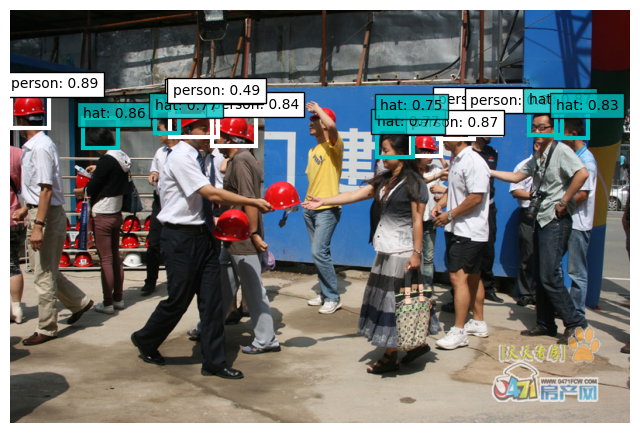

In [61]:
image_path = './2.jpg'
visualize_detections(image_path, detections['predictions'][0])

## 4 Autoscaling

- Knative Pod Autoscaler (KPA)
  - Part of the Knative Serving core and enabled by default once Knative Serving is installed.
  - Supports scale to zero functionality.
  - Does not support CPU-based autoscaling.
  
- Horizontal Pod Autoscaler (HPA)
  - Not part of the Knative Serving core, and must be enabled after Knative Serving installation.
  - Does not support scale to zero functionality.
  - Supports CPU-based autoscaling.

<span style="color:red">If you use CPU-based autotscaling, ake sure HPA is installed before move on </span> (check by `kubectl get deploy autoscaler-hpa -n knative-serving`), will need to install it from https://github.com/knative/serving/releases/

Add autoscaling tag to the InferenceService and apply

In [17]:
%%bash

cat << EOF | kubectl apply -f -
apiVersion: serving.kserve.io/v1beta1
kind: InferenceService
metadata:
  name: helmet-detection-serving
  annotations:
    autoscaling.knative.dev/class: hpa.autoscaling.knative.dev
    # see available tags: https://knative.dev/docs/serving/autoscaling/autoscaling-targets/
    autoscaling.knative.dev/max-scale: "3"
    # HPA: specifies the CPU percentage target (default "80"). 
    # KPA: Target x requests in-flight per pod.
    autoscaling.knative.dev/target: "80"  
spec:
  predictor:
    serviceAccountName: minio-service-account-user
    model:
      modelFormat:
        name: pytorch
      storageUri: "s3://helmet-bucket/helmet_detection"
      resources:
          requests:
            cpu: 50m
            memory: 200Mi
          limits:
            cpu: 100m
            memory: 500Mi
EOF

inferenceservice.serving.kserve.io/helmet-detection-serving configured


Check the number of pods. It takes a while before the one deployment get replaced.

In [18]:
!kubectl get pod

NAME                                                              READY   STATUS    RESTARTS   AGE
bitfusion-notebook-01-0                                           2/2     Running   0          61d
helmet-detection-0                                                2/2     Running   0          14d
helmet-detection-deployment-565dbfcffd-d6czf                      2/2     Running   0          12d
helmet-detection-serving-predictor-default-00001-deploymencl4dl   3/3     Running   0          3m19s
helmet-detection-serving-predictor-default-00002-deploymenlbnrq   2/3     Running   0          19s
ml-pipeline-ui-artifact-7cd897c59f-kzlfs                          2/2     Running   0          64d
ml-pipeline-visualizationserver-795f7db965-gzjsm                  2/2     Running   0          64d
model-serving-test-0                                              2/2     Running   0          15d
sklearn-iris-predictor-default-00001-deployment-5484f4d57-ld2fr   3/3     Running   0          15d


Adjust num of concurrent predict requests, fire it, let the the number of pods scale up

In [5]:
responses = bot.concurrent_predict(num=1)

fire 1 requests to helmet-detection-serving.kubeflow-user-example-com.example.com


Check the number of pods again

In [6]:
!kubectl get pod

NAME                                                              READY   STATUS    RESTARTS   AGE
bitfusion-notebook-01-0                                           2/2     Running   0          61d
helmet-detection-0                                                2/2     Running   0          14d
helmet-detection-deployment-565dbfcffd-d6czf                      2/2     Running   0          12d
helmet-detection-serving-predictor-default-00002-deploymenlbnrq   3/3     Running   0          12m
helmet-detection-serving-predictor-default-00002-deploymenqq46p   3/3     Running   0          62s
ml-pipeline-ui-artifact-7cd897c59f-kzlfs                          2/2     Running   0          64d
ml-pipeline-visualizationserver-795f7db965-gzjsm                  2/2     Running   0          64d
model-serving-test-0                                              2/2     Running   0          15d
sklearn-iris-predictor-default-00001-deployment-5484f4d57-ld2fr   3/3     Running   0          15d


## 5 Canary Rollout

In [7]:
%%bash

cat << EOF | kubectl apply -f -
apiVersion: serving.kserve.io/v1beta1
kind: InferenceService
metadata:
  name: helmet-detection-serving
  annotations:
    autoscaling.knative.dev/class: hpa.autoscaling.knative.dev
    autoscaling.knative.dev/target: "80"
    serving.kserve.io/enable-tag-routing: "true"
spec:
  predictor:
    serviceAccountName: minio-service-account-user
    model:
      modelFormat:
        name: pytorch
      storageUri: "s3://helmet-bucket/helmet_detection"
      resources:
          requests:
            cpu: 50m
            memory: 200Mi
          limits:
            cpu: 100m
            memory: 500Mi
EOF

inferenceservice.serving.kserve.io/helmet-detection-serving configured


In [8]:
!kubectl get revisions -l serving.kserve.io/inferenceservice=helmet-detection-serving

NAME                                               CONFIG NAME                                  K8S SERVICE NAME   GENERATION   READY     REASON      ACTUAL REPLICAS   DESIRED REPLICAS
helmet-detection-serving-predictor-default-00001   helmet-detection-serving-predictor-default                      1            True                  0                 0
helmet-detection-serving-predictor-default-00002   helmet-detection-serving-predictor-default                      2            True                  2                 2
helmet-detection-serving-predictor-default-00003   helmet-detection-serving-predictor-default                      3            Unknown   Deploying   1                 0


In [9]:
!kubectl get pods -l serving.kserve.io/inferenceservice=helmet-detection-serving

NAME                                                              READY   STATUS    RESTARTS   AGE
helmet-detection-serving-predictor-default-00002-deploymenlbnrq   3/3     Running   0          16m
helmet-detection-serving-predictor-default-00002-deploymenqq46p   3/3     Running   0          5m30s
helmet-detection-serving-predictor-default-00003-deploymenvdg7m   2/3     Running   0          24s


In [10]:
!kubectl get isvc helmet-detection-serving
!kubectl get isvc helmet-detection-serving -o yaml

NAME                       URL                                                                     READY   PREV   LATEST   PREVROLLEDOUTREVISION   LATESTREADYREVISION                                AGE
helmet-detection-serving   http://helmet-detection-serving.kubeflow-user-example-com.example.com   False          100                              helmet-detection-serving-predictor-default-00002   20m
apiVersion: serving.kserve.io/v1beta1
kind: InferenceService
metadata:
  annotations:
    autoscaling.knative.dev/class: hpa.autoscaling.knative.dev
    autoscaling.knative.dev/target: "80"
    kubectl.kubernetes.io/last-applied-configuration: |
      {"apiVersion":"serving.kserve.io/v1beta1","kind":"InferenceService","metadata":{"annotations":{"autoscaling.knative.dev/class":"hpa.autoscaling.knative.dev","autoscaling.knative.dev/target":"80","serving.kserve.io/enable-tag-routing":"true"},"name":"helmet-detection-serving","namespace":"kubeflow-user-example-com"},"spec":{"predictor":{"model

In [ ]:
responses = bot.concurrent_predict(10)
print("Number of Version 1: ", len(list(filter(lambda x: '"version": "1"' in x, responses))))
print("Number of Version 2: ", len(list(filter(lambda x: '"version": "2"' in x, responses))))
print(responses)

fire 10 requests to helmet-detection-serving.kubeflow-user-example-com.example.com


In [ ]:
bot.update_host('prev-helmet-detection-serving-predictor-default.user.example.com')
responses = bot.concurrent_predict(20)
print("Number of Version 1: ", len(list(filter(lambda x: '"version": "1"' in x, responses))))
print("Number of Version 2: ", len(list(filter(lambda x: '"version": "2"' in x, responses))))
print(responses)

In [ ]:
!kubectl patch isvc helmet-detection-serving --type='json' -p '[{"op": "replace", "path": "/spec/predictor/canaryTrafficPercent", "value": 50}]'

In [ ]:
!kubectl patch isvc helmet-detection-serving --type='json' -p '[{"op": "replace", "path": "/spec/predictor/canaryTrafficPercent", "value": 100}]'
!kubectl get isvc helmet-detection-serving
!kubectl get isvc helmet-detection-serving -o yaml

In [ ]:
!kubectl patch isvc helmet-detection-serving --type='json' -p '[{"op": "replace", "path": "/spec/predictor/canaryTrafficPercent", "value": 0}]'
!kubectl get isvc helmet-detection-serving
!kubectl get isvc helmet-detection-serving -o yaml

## 6 More
Explore the Kserve 0.8 docs here https://kserve.github.io/website/0.8/modelserving/control_plane/

(note that the version we use is KServe 0.6.1)

- Multi Model Serving
- Transformers
- Model Explainability
- Model Monitoring
- Payload Logging
- etc.
